# 03 — Multilingual mBERT Fine-Tuning & Cross-Lingual Transfer

Fine-tune `bert-base-multilingual-cased` (mBERT) under multiple training regimes to study cross-lingual transfer for sentiment analysis.

**Experiments:**
- **A**: mBERT trained on English only → evaluate on EN, FR, NL (zero-shot transfer)
- **B**: mBERT trained on all three languages → evaluate on each
- **C**: mBERT trained on French only → evaluate on all
- **D**: mBERT trained on Dutch only → evaluate on all

**Prerequisite:** Run `01_data_exploration.ipynb` first.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import torch
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
import evaluate

SEED = 42
MAX_LENGTH = 256
MBERT = "bert-base-multilingual-cased"
DATA_DIR = "./data"
MODEL_DIR = "./models"

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.10.0
CUDA available: False


## Shared Utilities

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from safetensors import safe_open
from safetensors.torch import save_file as safetensors_save_file

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        **accuracy_metric.compute(predictions=preds, references=labels),
        **f1_metric.compute(predictions=preds, references=labels),
        **precision_metric.compute(predictions=preds, references=labels),
        **recall_metric.compute(predictions=preds, references=labels),
    }


# Shared mBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(MBERT)


def tokenize_dataset(dataset):
    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=MAX_LENGTH,
        )
    cols_to_remove = [c for c in dataset.column_names if c not in ("label",)]
    tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=cols_to_remove)
    tokenized.set_format("torch")
    return tokenized


def get_training_args(output_dir, num_epochs=3):
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=4,
        fp16=torch.cuda.is_available(),
        gradient_checkpointing=True,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        max_grad_norm=1.0,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        logging_steps=100,
        report_to="none",
        seed=SEED,
        dataloader_num_workers=0,
        dataloader_pin_memory=False,
    )


def _patch_safetensors_inplace(path):
    """Rename gamma→weight and beta→bias keys in a safetensors file, in place."""
    if not os.path.isfile(path):
        return
    tensors = {}
    with safe_open(path, framework="pt", device="cpu") as f:
        metadata = f.metadata() or {}
        for key in f.keys():
            tensors[key] = f.get_tensor(key)

    if not any(k.endswith(".gamma") or k.endswith(".beta") for k in tensors):
        return  # already clean

    new_tensors = {}
    for key, val in tensors.items():
        if key.endswith(".gamma"):
            new_tensors[key[:-6] + ".weight"] = val
        elif key.endswith(".beta"):
            new_tensors[key[:-5] + ".bias"] = val
        else:
            new_tensors[key] = val

    tmp = path + ".tmp"
    safetensors_save_file(new_tensors, tmp, metadata=metadata)
    os.replace(tmp, path)


class CleanCheckpointTrainer(Trainer):
    """Trainer subclass that patches gamma/beta→weight/bias in every saved
    checkpoint immediately after saving, so load_best_model_at_end never
    encounters the legacy key names."""

    def _save_checkpoint(self, model, trial):
        super()._save_checkpoint(model, trial)
        # Only patch the checkpoint that was just written, not the entire output dir.
        # The trainer saves to a subfolder like checkpoint-<step> inside output_dir.
        ckpt_dir = self._get_output_dir(trial=trial)
        # Find the most-recently modified checkpoint-* subdirectory
        try:
            subdirs = [
                os.path.join(ckpt_dir, d)
                for d in os.listdir(ckpt_dir)
                if d.startswith("checkpoint-") and os.path.isdir(os.path.join(ckpt_dir, d))
            ]
            if not subdirs:
                return
            latest_ckpt = max(subdirs, key=os.path.getmtime)
            safetensor_path = os.path.join(latest_ckpt, "model.safetensors")
            if os.path.isfile(safetensor_path):
                try:
                    _patch_safetensors_inplace(safetensor_path)
                except Exception as e:
                    print(f"Warning: could not patch {safetensor_path}: {e}")
        except Exception as e:
            print(f"Warning: checkpoint patching skipped: {e}")

## Load Data

In [3]:
en_data = load_from_disk(os.path.join(DATA_DIR, "en"))
fr_data = load_from_disk(os.path.join(DATA_DIR, "fr"))
nl_data = load_from_disk(os.path.join(DATA_DIR, "nl"))
combined_data = load_from_disk(os.path.join(DATA_DIR, "combined"))

# Pre-tokenize all test sets (reused across experiments)
test_sets = {
    "en": tokenize_dataset(en_data["test"]),
    "fr": tokenize_dataset(fr_data["test"]),
    "nl": tokenize_dataset(nl_data["test"]),
}

print("Test set sizes:")
for lang, ds in test_sets.items():
    print(f"  {lang}: {len(ds)}")

Test set sizes:
  en: 25000
  fr: 20000
  nl: 2224


## Helper: Train mBERT and Evaluate on All Languages

In [4]:
all_results = []  # Collect results across experiments


def run_experiment(experiment_name, train_data, val_data, output_dir):
    """Train mBERT on given data and evaluate on all three languages."""
    print(f"\n{'='*60}")
    print(f"Experiment: {experiment_name}")
    print(f"Training size: {len(train_data)}")
    print(f"{'='*60}")

    model = AutoModelForSequenceClassification.from_pretrained(MBERT, num_labels=2)

    tok_train = tokenize_dataset(train_data)
    tok_val = tokenize_dataset(val_data)

    trainer = CleanCheckpointTrainer(
        model=model,
        args=get_training_args(output_dir),
        train_dataset=tok_train,
        eval_dataset=tok_val,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Evaluate on all three languages
    exp_results = {"experiment": experiment_name}
    for lang, test_ds in test_sets.items():
        metrics = trainer.evaluate(test_ds, metric_key_prefix=f"test_{lang}")
        exp_results[f"{lang}_accuracy"] = metrics[f"test_{lang}_accuracy"]
        exp_results[f"{lang}_f1"] = metrics[f"test_{lang}_f1"]
        print(f"  {lang.upper()} test - Accuracy: {metrics[f'test_{lang}_accuracy']:.4f}, F1: {metrics[f'test_{lang}_f1']:.4f}")

    # Save best model and tokenizer (also patch in case of gamma/beta)
    trainer.save_model(output_dir)
    _patch_safetensors_inplace(os.path.join(output_dir, "model.safetensors"))
    tokenizer.save_pretrained(output_dir)

    all_results.append(exp_results)
    return exp_results

## Experiment A: mBERT Trained on English Only (Zero-Shot Transfer)

In [5]:
exp_a = run_experiment(
    experiment_name="mBERT (EN only)",
    train_data=en_data["train"],
    val_data=en_data["validation"],
    output_dir=os.path.join(MODEL_DIR, "mbert-en-only"),
)


Experiment: mBERT (EN only)
Training size: 22500


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.175258,0.268099,0.892000,0.891217,0.897727,0.884800
2,0.848170,0.255852,0.897200,0.896994,0.898795,0.895200
3,0.517320,0.299588,0.902800,0.903380,0.898024,0.908800


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

  EN test - Accuracy: 0.8993, F1: 0.9007
  FR test - Accuracy: 0.8027, F1: 0.8217
  NL test - Accuracy: 0.7104, F1: 0.7486


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## Experiment B: mBERT Trained on All Three Languages

In [6]:
exp_b = run_experiment(
    experiment_name="mBERT (EN+FR+NL)",
    train_data=combined_data["train"],
    val_data=combined_data["validation"],
    output_dir=os.path.join(MODEL_DIR, "mbert-multilingual"),
)


Experiment: mBERT (EN+FR+NL)
Training size: 65528


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.117469,0.211702,0.916857,0.914916,0.920723,0.909181
2,0.767731,0.205855,0.925469,0.926037,0.904208,0.948946
3,0.590814,0.223096,0.929633,0.928884,0.923172,0.934667


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

  EN test - Accuracy: 0.9066, F1: 0.9067
  FR test - Accuracy: 0.9400, F1: 0.9377
  NL test - Accuracy: 0.8638, F1: 0.8658


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## Experiment C: mBERT Trained on French Only

In [7]:
exp_c = run_experiment(
    experiment_name="mBERT (FR only)",
    train_data=fr_data["train"],
    val_data=fr_data["validation"],
    output_dir=os.path.join(MODEL_DIR, "mbert-fr-only"),
)


Experiment: mBERT (FR only)
Training size: 25000


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.908914,0.256843,0.920650,0.922347,0.885725,0.962127
2,0.656664,0.192556,0.936300,0.934700,0.938645,0.930788
3,0.264015,0.259984,0.936400,0.935647,0.927482,0.943957


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

  EN test - Accuracy: 0.7951, F1: 0.8172
  FR test - Accuracy: 0.9402, F1: 0.9377
  NL test - Accuracy: 0.7122, F1: 0.7324


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## Experiment D: mBERT Trained on Dutch Only

In [8]:
exp_d = run_experiment(
    experiment_name="mBERT (NL only)",
    train_data=nl_data["train"],
    val_data=nl_data["validation"],
    output_dir=os.path.join(MODEL_DIR, "mbert-nl-only"),
)


Experiment: mBERT (NL only)
Training size: 18028


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
warmup_ratio is deprecated

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.655748,0.354356,0.833500,0.845905,0.787252,0.914000
2,1.276265,0.336788,0.846500,0.847945,0.840039,0.856000
3,0.785151,0.371161,0.851500,0.850978,0.853978,0.848000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

  EN test - Accuracy: 0.7614, F1: 0.7751
  FR test - Accuracy: 0.8172, F1: 0.8173
  NL test - Accuracy: 0.8548, F1: 0.8538


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

## Cross-Lingual Results Summary

In [9]:
df_results = pd.DataFrame(all_results)

print("Cross-Lingual Transfer Results (F1 Scores)")
print("=" * 60)

f1_cols = ["experiment", "en_f1", "fr_f1", "nl_f1"]
print(df_results[f1_cols].to_string(index=False, float_format="{:.4f}".format))

print("\nCross-Lingual Transfer Results (Accuracy)")
print("=" * 60)

acc_cols = ["experiment", "en_accuracy", "fr_accuracy", "nl_accuracy"]
print(df_results[acc_cols].to_string(index=False, float_format="{:.4f}".format))

# Save results
df_results.to_csv("./results/crosslingual_results.csv", index=False)
print("\nResults saved to ./results/crosslingual_results.csv")

Cross-Lingual Transfer Results (F1 Scores)
      experiment  en_f1  fr_f1  nl_f1
 mBERT (EN only) 0.9007 0.8217 0.7486
mBERT (EN+FR+NL) 0.9067 0.9377 0.8658
 mBERT (FR only) 0.8172 0.9377 0.7324
 mBERT (NL only) 0.7751 0.8173 0.8538

Cross-Lingual Transfer Results (Accuracy)
      experiment  en_accuracy  fr_accuracy  nl_accuracy
 mBERT (EN only)       0.8993       0.8027       0.7104
mBERT (EN+FR+NL)       0.9066       0.9400       0.8638
 mBERT (FR only)       0.7951       0.9402       0.7122
 mBERT (NL only)       0.7614       0.8172       0.8548

Results saved to ./results/crosslingual_results.csv


## Quick Visualization: Cross-Lingual Transfer Heatmap

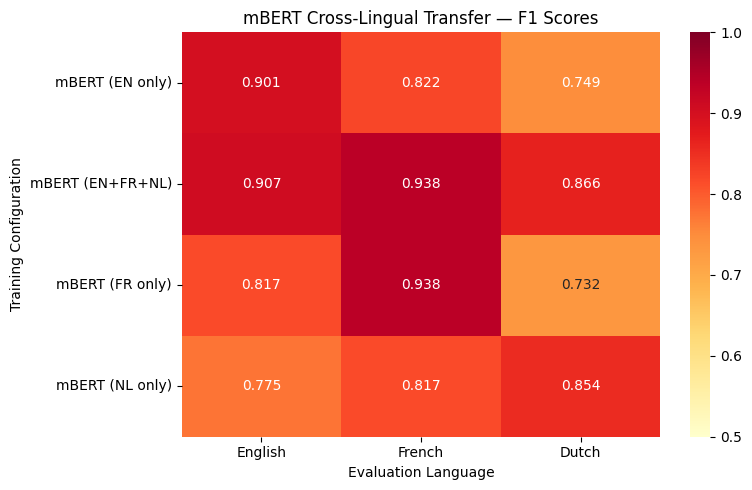

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap of F1 scores
heatmap_data = df_results.set_index("experiment")[["en_f1", "fr_f1", "nl_f1"]]
heatmap_data.columns = ["English", "French", "Dutch"]

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlOrRd",
    vmin=0.5,
    vmax=1.0,
    ax=ax,
)
ax.set_title("mBERT Cross-Lingual Transfer — F1 Scores")
ax.set_ylabel("Training Configuration")
ax.set_xlabel("Evaluation Language")

plt.tight_layout()
plt.savefig("./results/figures/crosslingual_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()